In [45]:
!head monthdata.csv

2018-02-11 00:00:00,2319.43
2018-02-11 00:05:00,2300.97
2018-02-11 00:10:00,2298.15
2018-02-11 00:15:00,2267.14
2018-02-11 00:20:00,2257.94
2018-02-11 00:25:00,2255.16
2018-02-11 00:30:00,2227.82
2018-02-11 00:35:00,2215.73
2018-02-11 00:40:00,2202.94
2018-02-11 00:45:00,2192.79


In [46]:
!tail monthdata.csv

2018-01-12 23:10:00,1979.1
2018-01-12 23:15:00,1933.21
2018-01-12 23:20:00,1936.22
2018-01-12 23:25:00,1913.13
2018-01-12 23:30:00,1892.44
2018-01-12 23:35:00,1865.02
2018-01-12 23:40:00,1832.58
2018-01-12 23:45:00,1816.05
2018-01-12 23:50:00,1778.73
2018-01-12 23:55:00,1776.77


In [47]:
#!/home/eee/ug/15084015/miniconda3/envs/TF/bin/python
"""
The script is to run half an hour after midnight. Scrap last day's data and update monthsdata.csv
"""
import os
import logging
from math import sqrt
from subprocess import call
from datetime import datetime, timedelta
import csv
import requests
import numpy as np
import pandas as pd
import statsmodels.api as sm
from bs4 import BeautifulSoup
from statsmodels.tsa.arima_model import ARIMAResults


In [48]:


# to store the log in a file called 'arima_log.txt'
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(message)s",
)
logger = logging.getLogger()
console = logging.StreamHandler()
logger.addHandler(console)


In [120]:


def get_data():
    return pd.read_csv(
        "monthdata.csv",
        header=None,
        index_col=["datetime"],
        names=["datetime", "load"],
        parse_dates=["datetime"],
        infer_datetime_format=True,
    )



In [122]:
if os.path.exists("monthdata.csv"):
    data = get_data()
    # import pdb; pdb.set_trace()
    if (datetime.today() - timedelta(1)).date().strftime('%Y-%m-%d') != str(data.index.date[-1]):  # yesterdays data not present, scrap it
        # only need to scrap for yesterday's data and append it to already existing file
        yesterday = datetime.today() - timedelta(1)
        yesterday = yesterday.strftime("%d/%m/%Y")
        get_load_data(yesterday)
        # re read updated monthdata.csv and clip data in monthdata.csv to last 30 days only
        data = get_data()
        day_to_clip_from = datetime.today() - timedelta(30)
        logger.info("Clipping data from " + day_to_clip_from.strftime("%d/%m/%Y"))
        data = data[day_to_clip_from.strftime("%d/%m/%Y"):]
        data.to_csv(
            "monthdata.csv", header=False
        )  # IMP: don't add any header to the monthdata.csv
    else:
        logger.info('Yesterday"s load already scrapped!')
else:  # scrap for last 30 days, prepare monthdata.csv
    for i in range(31, 0, -1):
        yesterday = datetime.today() - timedelta(i)
        yesterday = yesterday.strftime("%d/%m/%Y")
        get_load_data(yesterday)
    data = get_data()


Yesterday"s load already scrapped!
Yesterday"s load already scrapped!


In [121]:
data.index.date[-1]

datetime.date(2018, 12, 13)

In [115]:
(datetime.today() - timedelta(1)).date()

datetime.date(2018, 12, 13)

In [116]:
(datetime.today() - timedelta(1)).date() in data.index.date

True

In [117]:
(datetime.today() - timedelta(1)).date().strftime('%Y-%m-%d') == str(data.index.date[-1])

True

In [108]:
data = get_data()

# exit()


In [109]:
data.head()

,load
datetime,
2018-11-13 00:00:00,1905.57
2018-11-13 00:05:00,1886.34
2018-11-13 00:10:00,1844.60
2018-11-13 00:15:00,1872.64
2018-11-13 00:20:00,1820.45


In [110]:
data.tail()

,load
datetime,
2018-12-13 23:35:00,1953.89
2018-12-13 23:40:00,1928.33
2018-12-13 23:45:00,1918.94
2018-12-13 23:50:00,1882.72
2018-12-13 23:55:00,1862.48


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9792 entries, 2018-02-11 00:00:00 to 2018-01-12 23:55:00
Data columns (total 1 columns):
load    9792 non-null float64
dtypes: float64(1)
memory usage: 153.0 KB


In [80]:
# data[list(set(data.index.date))[0].strftime("%d/%m/%Y")]

In [99]:
1440/288

5.0

In [98]:
data['2018-01-12']

(1440, 1)

In [106]:
data['01/12/2018']

,load
datetime,
2018-01-12 00:00:00,1854.58
2018-01-12 00:05:00,1843.90
2018-01-12 00:10:00,1808.62
2018-01-12 00:15:00,1814.96
2018-01-12 00:20:00,1803.68
2018-01-12 00:25:00,1802.24
2018-01-12 00:30:00,1778.68
2018-01-12 00:35:00,1746.63
2018-01-12 00:40:00,1754.35


In [105]:
for idx, i in enumerate(sorted(set(data.index.date))):
    date = str(i)
    try:
    #     date = i.strftime("%d/%m/%Y")
        
#         data.loc[date] = data[date].asfreq(freq="30Min", method="bfill")
        data[date].asfreq(freq="30Min", method="bfill")
    except Exception as e:
        print(date)

        print(e)
print(idx)

2018-01-12
cannot reindex a non-unique index with a method or limit
29


In [89]:
data:

,load
datetime,
2018-02-11 00:00:00,2319.43
2018-02-11 00:05:00,2300.97
2018-02-11 00:10:00,2298.15
2018-02-11 00:15:00,2267.14
2018-02-11 00:20:00,2257.94
2018-02-11 00:25:00,2255.16
2018-02-11 00:30:00,2227.82
2018-02-11 00:35:00,2215.73
2018-02-11 00:40:00,2202.94


In [85]:

data.asfreq(freq="30Min")

,load
datetime,


In [53]:
data.shape[0]/288

34.0

In [58]:
data.asfreq(freq="30Min", method="bfill")  # sample the data in hourly manner


ValueError: cannot reindex a non-unique index with a method or limit

In [1]:

# initialize the model
# model = sm.tsa.statespace.SARIMAX(
#     data,
#     order=(3, 1, 1),
#     seasonal_order=(3, 0, 0, 24),
#     enforce_stationarity=False,
#     enforce_invertibility=False,
# )

# # fit the model with the data
# logger.info("Starting model fitting...")
# model = model.fit()

# logger.info("Model fitting done!!")
# logger.info(model.summary().tables[1])
# logger.info(model.summary())

# save the model
# model.save("ARIMA_month_model.pkl")
model = ARIMAResults.load('ARIMA_month_model.pkl')
# generate the predictions
todays_date = datetime.today().strftime("%d/%m/%Y")
tommorows_date = (datetime.today() + timedelta(1)).strftime("%d/%m/%Y")
pred = model.get_prediction(
    start=pd.to_datetime("%s 00:00:00" % todays_date),
    end=pd.to_datetime("%s 00:00:00" % tommorows_date),
    dynamic=False,
)


Scraping 27/11/2018
Done
Clipping data from 29/10/2018
(8640, 1)


In [2]:

# save the pridictions in a csv file
predictions = pred.predicted_mean
predictions = predictions.asfreq(freq="5Min", method="bfill")  # set to 5 min freq
date = datetime.today().strftime(format="%d-%m-%Y")
predictions.to_csv(
    "predictions/ARIMA/%s.csv" % date, index_label="datetime", header=["load"]
)

# error = sqrt(((predictions - numpy.squeeze(todays_date['%s' % date:]))**2).mean())
# logger.log(error)



In [9]:

predictions = predictions.rolling(window=10).mean()

In [10]:
from matplotlib import pyplot
%matplotlib inline

In [12]:
len(predictions.values)

289

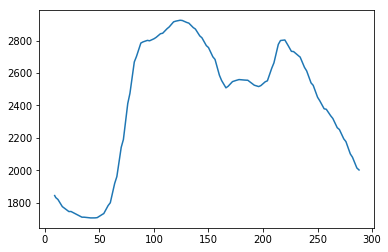

In [11]:
pyplot.plot(predictions.values)

In [13]:
data = pd.read_csv(
    "lstm_data.csv",
    header=None,
    names=["datetime", "load"],
    index_col=[0],
    parse_dates=[0],
    infer_datetime_format=True,
)

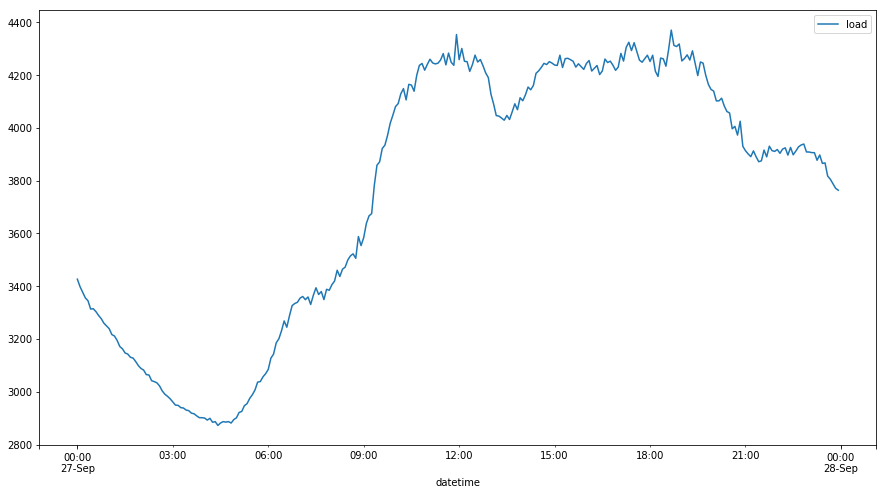

In [18]:
pyplot.rc('figure', figsize=(15.0, 8.0))

data['2018-09-27'].plot()
